In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import jax.numpy as jnp
import jax.random as jrandom

from plnn.models.algebraic_pl import AlgebraicPL
from plnn.pl import plot_phi


In [2]:
seed = 13234
rng = np.random.default_rng(seed=seed)

In [3]:
OUTDIR = "out"

In [4]:
SAVE_ANIMATION = True
DT0 = 0.01
SIGMA = 0.3

In [5]:
model, hyperparams = AlgebraicPL.make_model(
    key=jrandom.PRNGKey(0),
    dtype=jnp.float64,
    algebraic_phi_id="phi2",
    tilt_weights=[[1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma=SIGMA,
    signal_type="sigmoid",
    nsigparams=4,
    dt0=DT0,
)

In [6]:
key = jrandom.PRNGKey(rng.integers(2**32))

ncells = 100
x0_val = (-1.0, 0.0)
tfin = 20
burnin = 0.01
burnin_signal = (0, 1)
dtsave1 = 0.25
dtsave2 = 2.


# Define signal profile
sigparams = [[10, -0.25, -1.5, 0.5], [10, 1.5, -0.5, 0.25]]
sigparams = jnp.array(sigparams)

# Initial condition
key, subkey = jrandom.split(key, 2)
x0 = np.zeros([ncells, 2])
x0[:] = x0_val

# Simulate particles in the landscape
key, subkey = jrandom.split(key, 2)
ts_all, xs_all, sigs_all, ps_all = model.run_landscape_simulation(
    x0, tfin, [dtsave1, dtsave2], sigparams, subkey, 
    burnin=burnin
)

ts, ts_saved = ts_all
xs, xs_saved = xs_all
sigs, sigs_saved = sigs_all
ps, ps_saved = ps_all

In [7]:
from plnn.vectorfields import find_minima_along_tilt_trajectory
from plnn.vectorfields import check_minima_trajectories_for_bifurcations

minima = find_minima_along_tilt_trajectory(
    model, ps,
    ndivisions=10,
    n=20,
    tol=1e-1,
    x0_range=[[-4,4],[-4,4]],
    method="BFGS",
    opt_tol=1e-5,
)

bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
    ps, minima
)

Identified 2 potential bifurcation points...
At time t=8.75:
	tau=(-0.528, 0.803)
	mins0:
		[-1.08493099 -0.17962592]
		[ 0.81817725 -1.00854127]
	mins1:
		[-1.07585353 -0.16864151]
		[ 0.82162478 -1.0035872 ]
		[0.69206073 0.6294411 ]
At time t=14.25:
	tau=(-1.48, -0.287)
	mins0:
		[0.88929226 0.98098711]
		[-0.74873049  0.09457188]
		[ 0.85969822 -0.88231878]
	mins1:
		[0.89066134 0.9844823 ]
		[ 0.85870964 -0.87785254]
Starting points for potential bifurcations:
 [[-1.08493099 -0.17962592]
 [ 0.81817725 -1.00854127]
 [-1.07585353 -0.16864151]
 [ 0.82162478 -1.0035872 ]
 [ 0.69206073  0.6294411 ]
 [ 0.88929226  0.98098711]
 [-0.74873049  0.09457188]
 [ 0.85969822 -0.88231878]
 [ 0.89066134  0.9844823 ]
 [ 0.85870964 -0.87785254]]


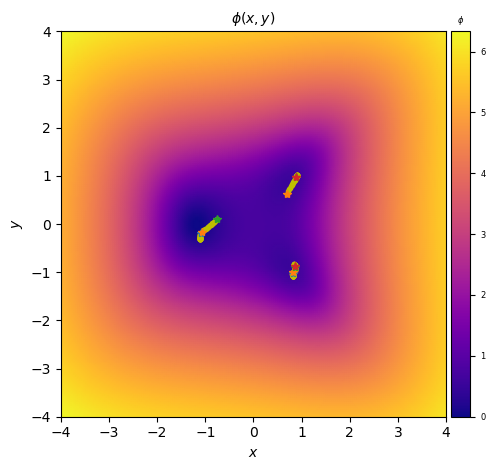

In [8]:
fig, ax = plt.subplots(1, 1)

print(f"Identified {len(bif_idxs)} potential bifurcation points...")
for i in range(len(bif_idxs)):
    tau0, tau1 = bif_tilts[i]
    mins0, mins1 = bif_mins[i]
    print(f"At time t={ts[bif_idxs[i]]}:")
    print(f"\ttau=({', '.join([f'{x:.3g}' for x in tau0])})")
    print(f"\tmins0:")
    for m in mins0:
        print(f"\t\t{m}")
    print(f"\tmins1:")
    for m in mins1:
        print(f"\t\t{m}")

plot_phi(
    model,
    tilt=[0,0],
    res=200,
    equal_axes=True,
    ax=ax,
    show=True,
)

for i in range(len(minima)):
    ax.plot(minima[i][:,0], minima[i][:,1], '.y');

for minset in bif_mins:
    for min in minset:
        ax.plot(min[:,0], min[:,1], '*');

print(f"Starting points for potential bifurcations:\n", bifs)

In [9]:
from cont.binary_flip import get_binary_flip_curves

bifseed1 = rng.integers(2**32)
bifseed2 = rng.integers(2**32)

landscape_tex = "$\phi$"

bifcurves, bifcolors = get_binary_flip_curves(seed=0, add_flip_curves=True)

# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors = [bifcolors[i] for i in keepidxs]


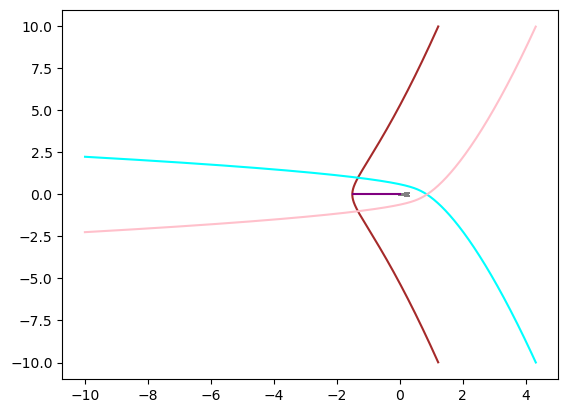

In [10]:
fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves)):
    curve = bifcurves[i]
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')

In [11]:
from plnn.helpers import get_phi2_fixed_points

fps, types, cols = get_phi2_fixed_points(ps)

In [12]:
for i, (fpset, typeset, colset, p) in enumerate(zip(fps, types, cols, ps)):
    print(i, p)
    for fp, t, c in zip(fpset, typeset, colset):
        print(fp, t, c)

0 [-0.25005675  1.4866143 ]
(0.819590750078388, -1.07891617778332) minimum pink
(-0.344827357033514, -0.562275576466630) saddle r
(-1.11093823256549, -0.308190933316670) minimum brown
1 [-0.25007286  1.48484552]
(0.819515165141149, -1.07872016769820) minimum pink
(-0.344619345242873, -0.562023974258605) saddle r
(-1.11100195684219, -0.307860021288772) minimum brown
2 [-0.25009356  1.48284503]
(0.819429900504080, -1.07849847132627) minimum pink
(-0.344384697898345, -0.561738848569895) saddle r
(-1.11107353121544, -0.307485731687727) minimum brown
3 [-0.25012013  1.48058305]
(0.819333776337691, -1.07824778490437) minimum pink
(-0.344120167883170, -0.561415728192011) saddle r
(-1.11115382237828, -0.307062480552469) minimum brown
4 [-0.25015424  1.47802611]
(0.819225486606689, -1.07796439748462) minimum pink
(-0.343822159872305, -0.561049543944380) saddle r
(-1.11124376249420, -0.306583993858563) minimum brown
5 [-0.25019805  1.4751367 ]
(0.819103591000285, -1.07764414585688) minimum pink


In [13]:
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.data_generation.simulate import phi2_field

duration = 10
dpi = 200
grid_size = 1

animator = PLNNSimulationAnimator(
    model, sigparams,
    ts, xs, sigs, ps, 
    ts_saved, xs_saved, sigs_saved, ps_saved, 
    xlims=[-4, 4], ylims=[-4, 4],
    p0lims=[-2, 2],
    p1lims=[-2, 2],
    # minima=minima,
    fixed_point_info=(fps, types, cols),
    grad_func=lambda x, y, p: phi2_field(None, np.array([x, y]).T, p).T,
    bifcurves=bifcurves,
    bifcolors=bifcolors,
    view_init=(45, 30),
)

ani = animator.animate(
    duration=duration,
    dpi=dpi,
    grid_width=grid_size,
    grid_height=grid_size,
    suptitle="Example Dynamics in the Binary Flip Landscape"
)
plt.close()

Generating movie...
Finished in 0.871 seconds.


In [14]:
HTML(ani.to_html5_video())

Generating movie...
Finished in 0.877 seconds.
Saving animation to out/phi2_ani_demo


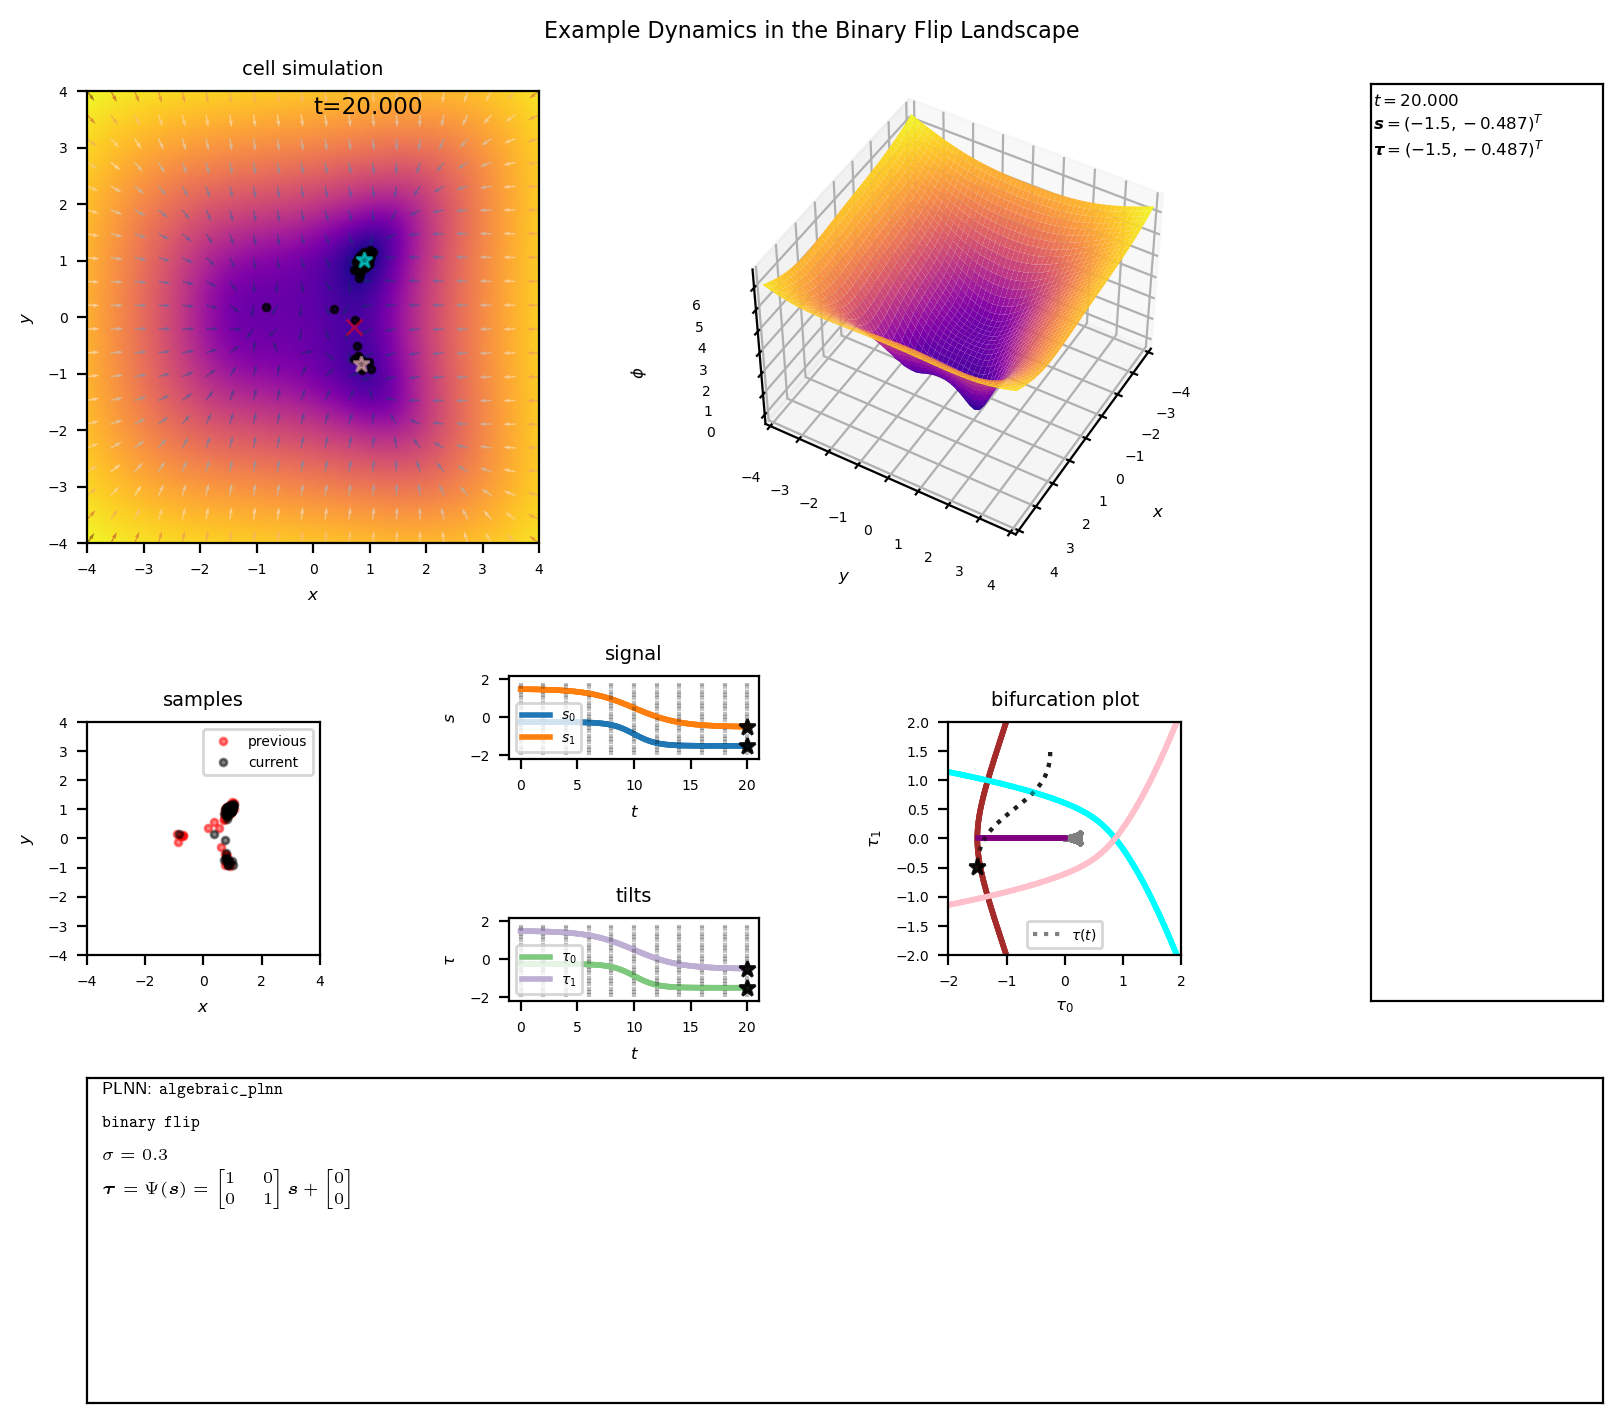

In [15]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi2_ani_demo",
        saveas='mp4',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        suptitle="Example Dynamics in the Binary Flip Landscape"
    )

Generating movie...
Finished in 0.784 seconds.
Saving animation to out/phi2_ani_demo


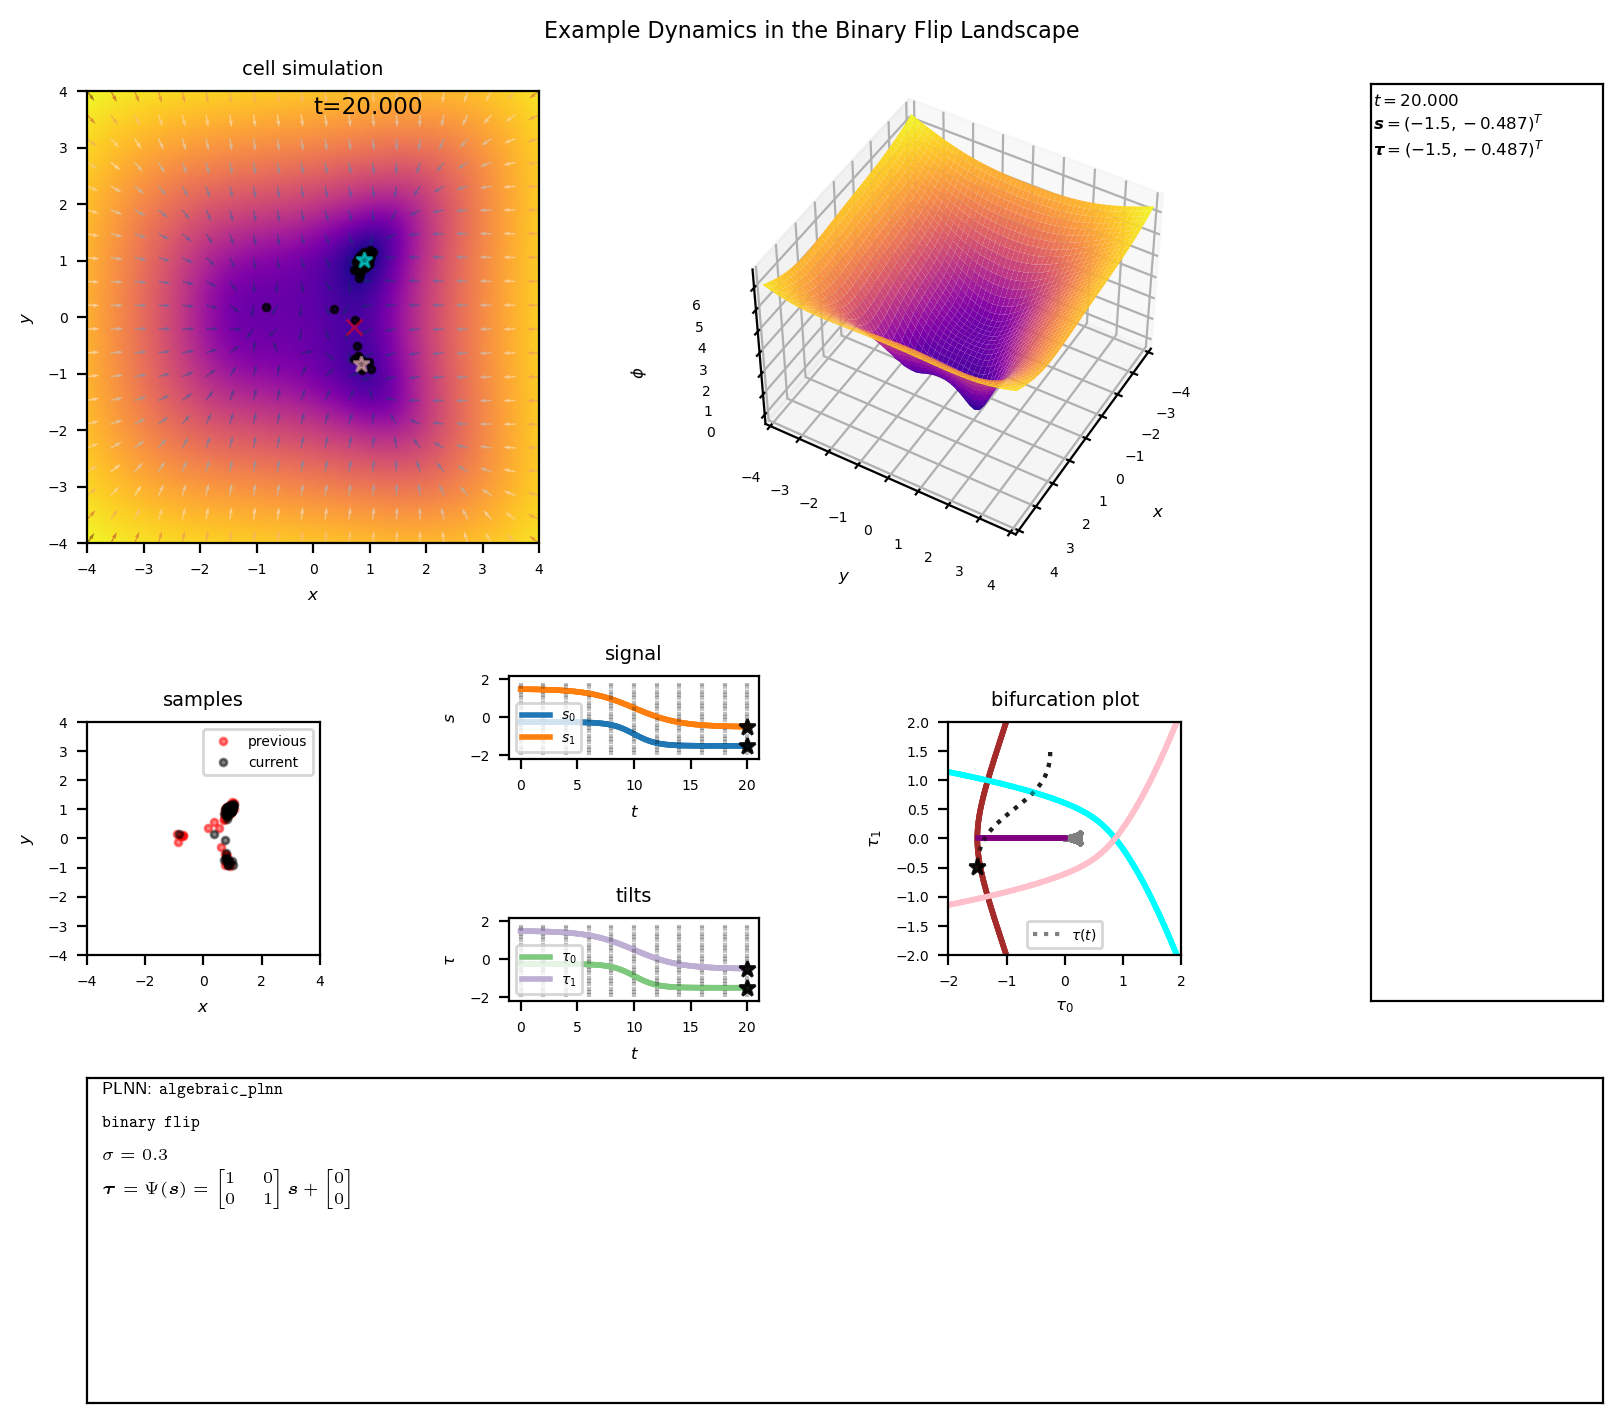

In [16]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi2_ani_demo",
        saveas='gif',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
        suptitle="Example Dynamics in the Binary Flip Landscape"
    )